In [0]:
import tensorflow as tf

In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class siamese:

    # Create model
    def __init__(self):
        self.x1 = tf.placeholder(tf.float32, [None, 4096])
        self.x2 = tf.placeholder(tf.float32, [None, 4096])

        with tf.variable_scope("siamese") as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)

        # Create loss
        self.y_ = tf.placeholder(tf.float32, None)
        
        self.loss = self.loss_with_spring()

    def network(self, x):
        weights = []
        fc1 = self.fc_layer(x, 1024, "fc1")
        ac1 = tf.nn.relu(fc1)
        fc2 = self.fc_layer(ac1, 125, "fc2")
        ac2 = tf.nn.relu(fc2)
        fc3 = self.fc_layer(ac2, 2, "fc3")
        
        return fc3

    def fc_layer(self, bottom, n_weight, name):
        assert len(bottom.get_shape()) == 2
        n_prev_weight = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        W = tf.get_variable(name+'W', dtype=tf.float32, shape=[n_prev_weight, n_weight], initializer=initer)
        b = tf.get_variable(name+'b', dtype=tf.float32, initializer=tf.constant(0.01, shape=[n_weight], dtype=tf.float32))
        fc = tf.nn.bias_add(tf.matmul(bottom, W), b)
        return fc

    def loss_with_spring(self):
        margin = 5.0
        labels_t = self.y_
        labels_f = tf.subtract(1.0, self.y_, name="1-yi")          # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(margin, name="C")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = tf.multiply(labels_t, eucd2, name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = tf.multiply(labels_f, tf.pow(tf.maximum(tf.subtract(C, eucd), 0), 2), name="Nyi_x_C-eucd_xx_2")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss

    def loss_with_step(self):
        margin = 5.0
        labels_t = self.y_
        labels_f = tf.subtract(1.0, self.y_, name="1-yi")          # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(margin, name="C")
        pos = tf.multiply(labels_t, eucd, name="y_x_eucd")
        neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C, eucd)), name="Ny_C-eucd")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss

In [0]:
sess = tf.InteractiveSession()

In [5]:
# setup siamese network                                                                                                                                
sia = siamese();
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(sia.loss)
saver = tf.train.Saver()
tf.initialize_all_variables().run()


W0711 08:56:58.598324 140508297389952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0711 08:56:58.741868 140508297389952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


####Siamese network

In [0]:
import numpy as np
x_train = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_train_collated/x_train_sky.npy')
f = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_train_collated/labels.npy')

In [0]:
f.shape

(58080,)

In [0]:
import numpy as np
a = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_train_collated/x_train_sky.npy')
b = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_train_collated/labels.npy').astype(int)
A = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_train_collated/x_train_sky.npy')
B = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_train_collated/labels.npy').astype(int)

In [0]:
c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)]
np.random.shuffle(c)
a2 = c[:, :a.size//len(a)].reshape(a.shape)
b2 = c[:, a.size//len(a):].reshape(b.shape) 

In [0]:
a = 0
b = 0

In [0]:
for i in range(len(b2)-1000):
    
    ds = []
    l = []
    di = []
    
    count2 = 0
    count1 = 0
    
    if i%1000==0:
    
        d = np.c_[A.reshape(len(A), -1), B.reshape(len(B), -1)]
        np.random.shuffle(d)
        a3 = d[:, :A.size//len(A)].reshape(A.shape)
        b3 = d[:, A.size//len(A):].reshape(B.shape)

    for j in range(len(b3)):
        
        if b2[i] == b3[j] and count1<100:
            l.append(1)
            ds.append(a2[i])
            di.append(a3[j])
            
            count1+=1
            
        else : 
            if count2<100:
                l.append(0)
                ds.append(a2[i])
                di.append(a3[j])
                count2+=1
                
                
        if count1 ==100 and count2==200:
            break
            
            
    di = np.asarray(di)        
    ds = np.asarray(ds)
    l = np.asarray(l)
    
    epoch = 10
    temp = 0
    
    for k in range(epoch):
        

        batch_x1 = ds

        batch_x2 = di


        batch_y = l

            

        _, loss_v = sess.run([train_step, sia.loss], feed_dict={
                            sia.x1: batch_x1,
                            sia.x2: batch_x2,
                            sia.y_: batch_y})


        if np.isnan(loss_v):
            print('Model diverged with loss = NaN')
            quit()
        temp = temp+loss_v

    
    if i%100 ==0:
        print(i)
        print ('loss %.3f' % (temp))

    
                
            
            
        

NameError: ignored

In [0]:
change = 20
epoch = 25
minloss = None


for i in range(change):
    print('change: '+str(i))
    
    c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)]
    np.random.shuffle(c)
    a2 = c[:, :a.size//len(a)].reshape(a.shape)
    b2 = c[:, a.size//len(a):].reshape(b.shape)  
          
    
    d = np.c_[A.reshape(len(A), -1), B.reshape(len(B), -1)]
    np.random.shuffle(d)
    a3 = d[:, :A.size//len(A)].reshape(A.shape)
    b3 = d[:, A.size//len(A):].reshape(B.shape)  
          
        
    for i in range(epoch):
        batch_size = 128
        x = 0
        temp = 0
        print('epoch: '+str(i))

        for step in range(436):
            cur = x + batch_size

            batch_x1 = a2[ x : cur ]
            batch_y1 = b2[ x : cur]

            batch_x2 = a3[ x : cur ]
            batch_y2 = b3[ x : cur ]

            batch_y = (batch_y1 == batch_y2).astype('float')

            _, loss_v = sess.run([train_step, sia.loss], feed_dict={
                                sia.x1: batch_x1,
                                sia.x2: batch_x2,
                                sia.y_: batch_y})
            temp = temp+loss_v

            if np.isnan(loss_v):
                print('Model diverged with loss = NaN')
                quit()
            x = x + batch_size
        print ('loss %.3f' % (temp))
        


change: 0
epoch: 0
loss 1385.013
epoch: 1
loss 562.448
epoch: 2
loss 530.067
epoch: 3
loss 515.792
epoch: 4
loss 505.917
epoch: 5
loss 493.845
epoch: 6
loss 489.279
epoch: 7
loss 481.171
epoch: 8
loss 481.378
epoch: 9
loss 469.964
epoch: 10
loss 465.475
epoch: 11
loss 462.275
epoch: 12
loss 458.026
epoch: 13
loss 455.391
epoch: 14
loss 451.659
epoch: 15
loss 448.457
epoch: 16
loss 445.776
epoch: 17
loss 445.137
epoch: 18
loss 442.840
epoch: 19
loss 438.352
epoch: 20
loss 436.613
epoch: 21
loss 433.539
epoch: 22
loss 431.349
epoch: 23
loss 429.876
epoch: 24
loss 428.626
change: 1
epoch: 0
loss 618.861
epoch: 1
loss 593.064
epoch: 2
loss 576.350
epoch: 3
loss 567.119
epoch: 4
loss 562.036
epoch: 5
loss 559.100
epoch: 6
loss 552.379
epoch: 7
loss 547.659
epoch: 8
loss 542.722
epoch: 9
loss 536.673
epoch: 10
loss 532.296
epoch: 11
loss 525.288
epoch: 12
loss 526.275
epoch: 13
loss 521.799
epoch: 14
loss 518.531
epoch: 15
loss 515.323
epoch: 16
loss 512.608
epoch: 17
loss 508.511
epoch: 18


In [0]:
saver.save(sess, '/content/gdrive/My Drive/models/siamese/sketchmodel')

'/content/gdrive/My Drive/models/siamese/sketchmodel'

In [0]:
!pip install openTSNE

     |████████████████████████████████| 839kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/82/66/5c/ff15e5b7c0fd8cf975379e972826fd51201ba12701688656c3
  Stored in directory: /root/.cache/pip/wheels/c2/dc/94/2055c891994f758c6453808c69b6ce852672e5e9c426c56717
Successfully built openTSNE pynndescent


In [0]:
x_test = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_test_collated/final.npy')
f = np.load('/content/gdrive/My Drive/feature_vectors_final/sketches_test_collated/labels.npy')

x_train_skt = sess.run(sia.o1, feed_dict={sia.x1:x_test})

from openTSNE import TSNE


tsne = TSNE().fit(x_train_skt)

In [0]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(20, 20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.set_facecolor('w')
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=10)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)


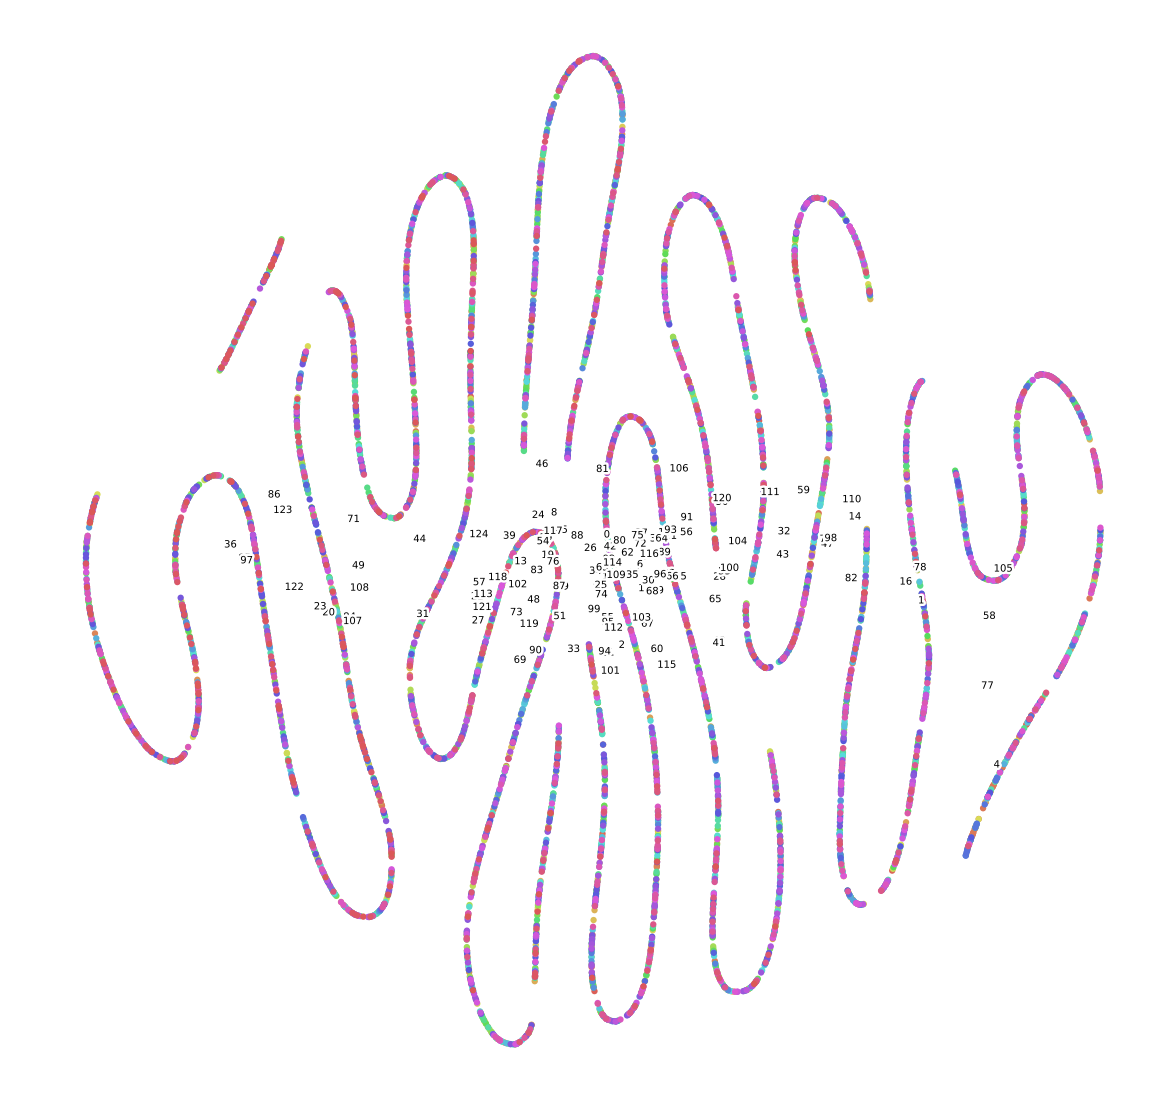

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
fashion_scatter(tsne, f) 

####MAP

In [0]:
def eval_MAP_K(query_set, search_set, query_label, search_set_label, K):
    query_class_arr = query_set
    search_set_class_arr = search_set

    query_label_arr = query_label
    query_label_arr.astype(int)
    search_set_label_arr = search_set_label
    search_set_label_arr.astype(int)

    num_query_sample = query_label_arr.shape[0]

    dist_q_search_class = cdist(query_class_arr,search_set_class_arr,metric='euclidean')

    AP=0
    for query_count in range(0,num_query_sample):

        actual_label = query_label_arr[query_count]
        value=dist_q_search_class[query_count,:]
        sorted_value_idx=value.argsort()
        predicted_K_label = search_set_label_arr[sorted_value_idx[0:K]]
        L=np.sum((np.in1d(predicted_K_label,actual_label)).astype(int))

        P=0
        for r in range(0,K):
            rtr_label_r = predicted_K_label[:(r+1)]
            l=np.sum((np.in1d(rtr_label_r,actual_label)).astype(int))
            precision=l/(r+1)
            if actual_label==predicted_K_label[r]:
                delta=1
            else:
                delta=0
            P=P+(precision*delta)
        if L!=0:
            AP=AP+((1/L)*P)
    map_K=AP/num_query_sample
    return map_K

In [0]:
import numpy as np
x_test = np.load('/content/gdrive/My Drive/image features/xtest.npy')
f = np.load('/content/gdrive/My Drive/image features/xtest.npy')

In [0]:
x_train_skt = sess.run(sia.o1, feed_dict={sia.x1:x_test})

In [12]:
from scipy.spatial.distance import cdist

eval_MAP_K(x_test,x_test, f, f, 100)

KeyboardInterrupt: ignored

In [0]:
from scipy.spatial.distance import cdist

eval_MAP_K(a,A,b,B,100)

In [0]:
x_train_skt.shape

(7342, 125)